In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import expipe
import pathlib
import numpy as np
import spatial_maps.stats as stats
import septum_mec
import septum_mec.analysis.data_processing as dp
import septum_mec.analysis.registration
import head_direction.head as head
import spatial_maps as sp
import speed_cells.speed as spd
import re
import joblib
import multiprocessing
import shutil
import psutil
import pandas as pd
import matplotlib.pyplot as plt
from distutils.dir_util import copy_tree
from neo import SpikeTrain
import scipy

from tqdm.notebook import tqdm_notebook as tqdm
tqdm.pandas()

from spike_statistics.core import permutation_resampling

from spikewaveform.core import calculate_waveform_features_from_template, cluster_waveform_features

from septum_mec.analysis.plotting import violinplot

08:31:25 [I] klustakwik KlustaKwik2 version 0.2.6


In [3]:
%matplotlib inline
color_control = '#4393c3'
color_stimulated = '#d6604d'

color_bs = '#5aae61'
color_ns = '#9970ab'

figsize_violin = (1.7, 3)
figsize_gen = (4, 3)

output_path = pathlib.Path("output") / "waveform-analysis"
(output_path / "statistics").mkdir(exist_ok=True, parents=True)
(output_path / "figures").mkdir(exist_ok=True, parents=True)
output_path.mkdir(exist_ok=True)

In [4]:
data_loader = dp.Data()
actions = data_loader.actions
project = data_loader.project

In [5]:
identify_neurons = actions['identify-neurons']
sessions = pd.read_csv(identify_neurons.data_path('sessions'))
units = pd.read_csv(identify_neurons.data_path('units'))
session_units = pd.merge(sessions, units, on='action')
#########################3
# session_units = session_units.drop_duplicates('unit_id')
#################################
print('N cells:',session_units.shape[0])

N cells: 1284


In [6]:
session_units.head()

,action,baseline,entity,frequency,i,ii,session,stim_location,stimulated,tag,date,entity_date,Hz11,Hz30,channel_group,max_depth_delta,max_dissimilarity,unit_id,unit_idnum,unit_name
0,1849-060319-3,True,1849,NaN,False,True,3,NaN,False,baseline ii,60319,1849-060319,False,True,1,100,0.05,f129d848-ebee-4555-965f-420e402eb820,703,104
1,1849-060319-3,True,1849,NaN,False,True,3,NaN,False,baseline ii,60319,1849-060319,False,True,1,100,0.05,b50f3878-32aa-40e9-8753-9f401ef32a23,704,108
2,1849-060319-3,True,1849,NaN,False,True,3,NaN,False,baseline ii,60319,1849-060319,False,True,1,100,0.05,b1626e1a-0469-4ee0-a812-88ee18accd39,705,85
3,1849-060319-3,True,1849,NaN,False,True,3,NaN,False,baseline ii,60319,1849-060319,False,True,1,100,0.05,feb62d54-f173-4a3c-939c-8c1465e71b0f,706,94
4,1849-060319-3,True,1849,NaN,False,True,3,NaN,False,baseline ii,60319,1849-060319,False,True,1,100,0.05,3498a09b-b943-4917-866a-8910dbcfd0cd,707,98


In [7]:
# session_units.groupby('action').count().unit_name.hist()
session_units.groupby('action').count().sort_values('unit_name', ascending=False).unit_name

action
1833-010719-2    33
1833-010719-1    29
1833-290519-1    28
1833-020719-3    27
1849-280219-1    26
                 ..
1849-110319-3     4
1839-060619-4     4
1839-060619-3     4
1839-120619-1     3
1839-060619-1     2
Name: unit_name, Length: 87, dtype: int64

# Process all data

In [8]:
def features(row):
    action_id = row['action']
    channel_id = row['channel_group']
    unit = row['unit_name']
    template = data_loader.template(action_id, channel_id, unit)
    spike_times = data_loader.spike_train(action_id, channel_id, unit)
    half_widths, peak_to_troughs = calculate_waveform_features_from_template(
        template.data, template.sampling_rate)
    peak_amps = template.data.min(axis=1)
    half_widths = half_widths * 1000 # to ms
    peak_to_troughs = peak_to_troughs * 1000 # to ms
    idxs = np.argsort(peak_amps)
    peak_to_trough = np.nan
    for p2t in peak_to_troughs[idxs]:
        if np.isfinite(p2t) and p2t > .1:
            peak_to_trough = p2t
            break
    half_width = np.nan
    for hw in half_widths[idxs]:
        if np.isfinite(hw):
            half_width = hw
            break
    
    return pd.Series({
        'half_width': half_width,
        'peak_to_trough': peak_to_trough,
        'average_firing_rate': float(len(spike_times) / spike_times.t_stop),
        'template': template.data[idxs[0]]
    })

In [9]:
results = session_units.merge(
    session_units.progress_apply(features, axis=1), 
    left_index=True, right_index=True)

In [ ]:
%debug

> /home/mikkel/apps/expipe-project/septum-mec/septum_mec/analysis/data_processing.py(619)template()
    617                     lim=lim)
    618             }
--> 619         return self._templates[action_id][channel_group][unit_id]
    620 
    621     def spike_train(self, action_id, channel_group, unit_id):

ipdb> action_id
'1834-010319-3'
ipdb> channel_group
0
ipdb> unit_id
72


In [10]:
df = results.loc[:, ['half_width', 'peak_to_trough']].dropna()

idxs_df = cluster_waveform_features(df.half_width, df.peak_to_trough)

results.loc[df.index, 'bs'] = idxs_df

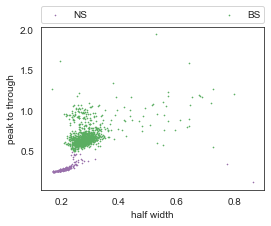

In [11]:
plt.figure(figsize=figsize_gen)
size = 5
mew = .5
marker_bs = '.'
marker_ns = '+'

plt.scatter(
    results.query('bs==0')['half_width'], 
    results.query('bs==0')['peak_to_trough'], 
    c=color_ns, s=size, marker=marker_ns, linewidth=mew, label='NS')

plt.scatter(
    results.query('bs==1')['half_width'], 
    results.query('bs==1')['peak_to_trough'], 
    c=color_bs, s=size, marker=marker_bs, linewidth=mew, label='BS')

plt.xlabel('half width')
plt.ylabel('peak to through')

plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=2)

plt.savefig(output_path / "figures" / "clusters.svg", bbox_inches="tight")
plt.savefig(output_path / "figures" / "clusters.png", dpi=600, bbox_inches="tight")

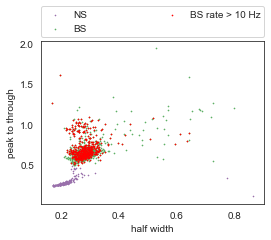

In [12]:
plt.figure(figsize=figsize_gen)

size = 5
mew = .5
marker_bs = '.'
marker_ns = '+'

plt.scatter(
    results.query('bs==0')['half_width'], 
    results.query('bs==0')['peak_to_trough'], 
    c=color_ns, s=size, marker=marker_ns, linewidth=mew, label='NS')

plt.scatter(
    results.query('bs==1')['half_width'], 
    results.query('bs==1')['peak_to_trough'], 
    c=color_bs, s=size, marker=marker_bs, linewidth=mew, label='BS')

plt.scatter(
    results.query('bs==1 and average_firing_rate > 10')['half_width'], 
    results.query('bs==1 and average_firing_rate > 10')['peak_to_trough'], 
    c='red', s=size, marker=marker_bs, linewidth=mew, label='BS rate > 10 Hz')

plt.xlabel('half width')
plt.ylabel('peak to through')

plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=2)

plt.savefig(output_path / "figures" / "clusters_and_rate.svg", bbox_inches="tight")
plt.savefig(output_path / "figures" / "clusters_and_rate.png", dpi=600, bbox_inches="tight")

In [13]:
stim = results.query('stimulated').loc[:, ['half_width', 'peak_to_trough']].dropna()

idxs_stim = cluster_waveform_features(stim.half_width, stim.peak_to_trough)

results.loc[stim.index, 'bs_stim'] = idxs_stim

In [14]:
control = results.query('not stimulated').loc[:, ['half_width', 'peak_to_trough']].dropna()

idxs_control = cluster_waveform_features(control.half_width, control.peak_to_trough)

results.loc[control.index, 'bs_ctrl'] = idxs_control

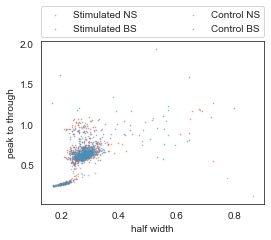

In [15]:
plt.figure(figsize=figsize_gen)
size = 5
mew = .5
marker_bs = '.'
marker_ns = '+'
plt.scatter(
    results.query('bs_stim==0')['half_width'], 
    results.query('bs_stim==0')['peak_to_trough'], 
    c=color_stimulated, s=size, marker=marker_ns, 
    linewidth=mew, label='Stimulated NS', alpha=.5)

plt.scatter(
    results.query('bs_stim==1')['half_width'], 
    results.query('bs_stim==1')['peak_to_trough'], 
    c=color_stimulated, s=size, marker=marker_bs, 
    linewidth=mew, label='Stimulated BS', alpha=.5)


plt.scatter(
    results.query('bs_ctrl==0')['half_width'], 
    results.query('bs_ctrl==0')['peak_to_trough'], 
    c=color_control, s=size, marker=marker_ns, 
    linewidth=mew, label='Control NS', alpha=.5)

plt.scatter(
    results.query('bs_ctrl==1')['half_width'], 
    results.query('bs_ctrl==1')['peak_to_trough'], 
    c=color_control, s=size, marker=marker_bs, 
    linewidth=mew, label='Control BS', alpha=.5)

plt.xlabel('half width')
plt.ylabel('peak to through')
plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=2)

plt.savefig(output_path / "figures" / "compare-clusters.svg", bbox_inches="tight")
plt.savefig(output_path / "figures" / "compare-clusters.png", dpi=600, bbox_inches="tight")

In [16]:
results.average_firing_rate = results.apply(lambda x: float(x.average_firing_rate), axis=1)

In [17]:
results.frequency = results.apply(
    lambda x: 
        float(x.frequency.replace('Hz', '')) if isinstance(x.frequency, str) 
        else float(x.frequency), axis=1)

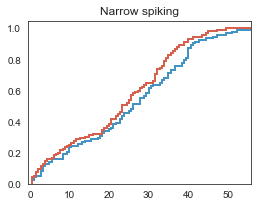

In [18]:
bins=100
density=True
cumulative=True
histtype='step'
lw = 2

plt.figure(figsize=figsize_gen)
plt.title('Narrow spiking')
_, bins, _ = plt.hist(
    results.query('bs_ctrl==0')['average_firing_rate'], 
    bins=bins, density=density, cumulative=cumulative, 
    histtype=histtype, color=color_control, lw=lw, label='Control');

_, bins, _ = plt.hist(
    results.query('bs_stim==0')['average_firing_rate'], 
    bins=bins, density=density, cumulative=cumulative, 
    histtype=histtype, color=color_stimulated, lw=lw, label='Stimulated');

plt.xlim(-.5, 56)
# plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
#                 mode="expand", borderaxespad=0, ncol=2)

plt.savefig(output_path / "figures" / "cumulative_ns.svg", bbox_inches="tight")
plt.savefig(output_path / "figures" / "cumulative_ns.png", dpi=600, bbox_inches="tight")

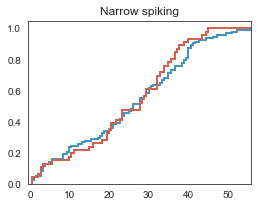

In [19]:
bins=100
density=True
cumulative=True
histtype='step'
lw = 2

plt.figure(figsize=figsize_gen)
plt.title('Narrow spiking')
_, bins, _ = plt.hist(
    results.query('bs_ctrl==0')['average_firing_rate'], 
    bins=bins, density=density, cumulative=cumulative, 
    histtype=histtype, color=color_control, lw=lw, label='Control');

_, bins, _ = plt.hist(
    results.query('bs_stim==0 and frequency==30')['average_firing_rate'], 
    bins=bins, density=density, cumulative=cumulative, 
    histtype=histtype, color=color_stimulated, lw=lw, label='Stimulated');

plt.xlim(-.5, 56)
# plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
#                 mode="expand", borderaxespad=0, ncol=2)

plt.savefig(output_path / "figures" / "cumulative_ns_30.svg", bbox_inches="tight")
plt.savefig(output_path / "figures" / "cumulative_ns_30.png", dpi=600, bbox_inches="tight")

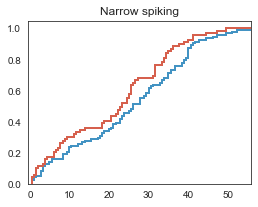

In [20]:
bins=100
density=True
cumulative=True
histtype='step'
lw = 2

plt.figure(figsize=figsize_gen)
plt.title('Narrow spiking')
_, bins, _ = plt.hist(
    results.query('bs_ctrl==0')['average_firing_rate'], 
    bins=bins, density=density, cumulative=cumulative, 
    histtype=histtype, color=color_control, lw=lw, label='Control');

_, bins, _ = plt.hist(
    results.query('bs_stim==0 and frequency==11')['average_firing_rate'], 
    bins=bins, density=density, cumulative=cumulative, 
    histtype=histtype, color=color_stimulated, lw=lw, label='Stimulated');

plt.xlim(-.5, 56)
# plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
#                 mode="expand", borderaxespad=0, ncol=2)

plt.savefig(output_path / "figures" / "cumulative_ns_11.svg", bbox_inches="tight")
plt.savefig(output_path / "figures" / "cumulative_ns_11.png", dpi=600, bbox_inches="tight")

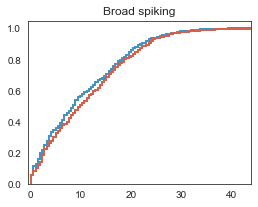

In [21]:
bins = 100

plt.figure(figsize=figsize_gen)
plt.title('Broad spiking')
_, bins, _ = plt.hist(
    results.query('bs_ctrl==1')['average_firing_rate'], 
    bins=bins, density=density, cumulative=cumulative, 
    histtype=histtype, color=color_control, lw=lw);

_, bins, _ = plt.hist(
    results.query('bs_stim==1')['average_firing_rate'], 
    bins=bins, density=density, cumulative=cumulative, 
    histtype=histtype, color=color_stimulated, lw=lw);

plt.xlim(-.5, 44)

plt.savefig(output_path / "figures" / "cumulative_bs.svg", bbox_inches="tight")
plt.savefig(output_path / "figures" / "cumulative_bs.png", dpi=600, bbox_inches="tight")

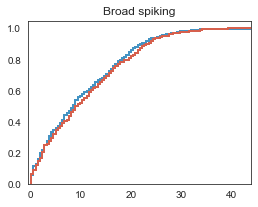

In [22]:
bins = 100

plt.figure(figsize=figsize_gen)
plt.title('Broad spiking')
_, bins, _ = plt.hist(
    results.query('bs_ctrl==1')['average_firing_rate'], 
    bins=bins, density=density, cumulative=cumulative, 
    histtype=histtype, color=color_control, lw=lw);

_, bins, _ = plt.hist(
    results.query('bs_stim==1 and frequency==11')['average_firing_rate'], 
    bins=bins, density=density, cumulative=cumulative, 
    histtype=histtype, color=color_stimulated, lw=lw);

plt.xlim(-.5, 44)

plt.savefig(output_path / "figures" / "cumulative_bs_11.svg", bbox_inches="tight")
plt.savefig(output_path / "figures" / "cumulative_bs_11.png", dpi=600, bbox_inches="tight")

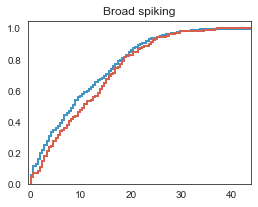

In [23]:
bins = 100

plt.figure(figsize=figsize_gen)
plt.title('Broad spiking')
_, bins, _ = plt.hist(
    results.query('bs_ctrl==1')['average_firing_rate'], 
    bins=bins, density=density, cumulative=cumulative, 
    histtype=histtype, color=color_control, lw=lw);

_, bins, _ = plt.hist(
    results.query('bs_stim==1 and frequency==30')['average_firing_rate'], 
    bins=bins, density=density, cumulative=cumulative, 
    histtype=histtype, color=color_stimulated, lw=lw);

plt.xlim(-.5, 44)

plt.savefig(output_path / "figures" / "cumulative_bs_30.svg", bbox_inches="tight")
plt.savefig(output_path / "figures" / "cumulative_bs_30.png", dpi=600, bbox_inches="tight")

U-test: U value 135025.0 p value 0.11036062942886643
U-test: U value 6176.0 p value 0.12484872783599776


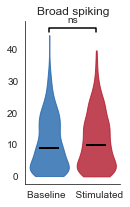

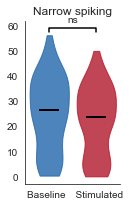

In [24]:
plt.figure(figsize=figsize_violin)
# test = 'permutation_resampling'
test = 'mann_whitney'

plt.title('Broad spiking')
violinplot(
    results.query('bs_ctrl==1')['average_firing_rate'].to_numpy(), 
    results.query('bs_stim==1')['average_firing_rate'].to_numpy(), 
    test=test)

plt.savefig(output_path / "figures" / "rates_bs.svg", bbox_inches="tight")
plt.savefig(output_path / "figures" / "rates_bs.png", dpi=600, bbox_inches="tight")

plt.figure(figsize=figsize_violin)
plt.title('Narrow spiking')
violinplot(
    results.query('bs_ctrl==0')['average_firing_rate'].to_numpy(), 
    results.query('bs_stim==0')['average_firing_rate'].to_numpy(), 
    test=test)

plt.savefig(output_path / "figures" / "rates_ns.svg", bbox_inches="tight")
plt.savefig(output_path / "figures" / "rates_ns.png", dpi=600, bbox_inches="tight")

U-test: U value 85419.0 p value 0.4550292852318226
U-test: U value 3843.0 p value 0.06623560612855536


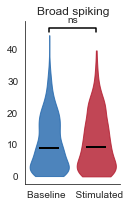

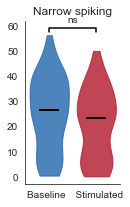

In [25]:
plt.figure(figsize=figsize_violin)
# test = 'permutation_resampling'
test = 'mann_whitney'

plt.title('Broad spiking')
violinplot(
    results.query('bs_ctrl==1')['average_firing_rate'].to_numpy(), 
    results.query('bs_stim==1 and frequency==11')['average_firing_rate'].to_numpy(), 
    test=test)

plt.savefig(output_path / "figures" / "rates_bs_11.svg", bbox_inches="tight")
plt.savefig(output_path / "figures" / "rates_bs_11.png", dpi=600, bbox_inches="tight")

plt.figure(figsize=figsize_violin)
plt.title('Narrow spiking')
violinplot(
    results.query('bs_ctrl==0')['average_firing_rate'].to_numpy(), 
    results.query('bs_stim==0 and frequency==11')['average_firing_rate'].to_numpy(), 
    test=test)

plt.savefig(output_path / "figures" / "rates_ns_11.svg", bbox_inches="tight")
plt.savefig(output_path / "figures" / "rates_ns_11.png", dpi=600, bbox_inches="tight")

U-test: U value 49606.0 p value 0.03757091416858637
U-test: U value 2333.0 p value 0.5891054506000802


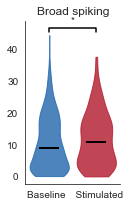

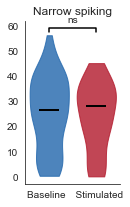

In [26]:
plt.figure(figsize=figsize_violin)
# test = 'permutation_resampling'
test = 'mann_whitney'

plt.title('Broad spiking')
violinplot(
    results.query('bs_ctrl==1')['average_firing_rate'].to_numpy(), 
    results.query('bs_stim==1 and frequency==30')['average_firing_rate'].to_numpy(), 
    test=test)

plt.savefig(output_path / "figures" / "rates_bs.svg", bbox_inches="tight")
plt.savefig(output_path / "figures" / "rates_bs.png", dpi=600, bbox_inches="tight")

plt.figure(figsize=figsize_violin)
plt.title('Narrow spiking')
violinplot(
    results.query('bs_ctrl==0')['average_firing_rate'].to_numpy(), 
    results.query('bs_stim==0 and frequency==30')['average_firing_rate'].to_numpy(), 
    test=test)

plt.savefig(output_path / "figures" / "rates_ns_30.svg", bbox_inches="tight")
plt.savefig(output_path / "figures" / "rates_ns_30.png", dpi=600, bbox_inches="tight")

In [27]:
columns = [
    'average_firing_rate',
    'half_width',
    'peak_to_trough'
]


def summarize(data):
    return "{:.2f} ± {:.2f} ({})".format(data.mean(), data.sem(), sum(~np.isnan(data)))


bs = pd.DataFrame()

bs['Control'] = results.query('bs_ctrl==1')[columns].agg(summarize)
bs['Stimulated'] = results.query('bs_stim==1')[columns].agg(summarize)

ns = pd.DataFrame()

ns['Control'] = results.query('bs_ctrl==0')[columns].agg(summarize)
ns['Stimulated'] = results.query('bs_stim==0')[columns].agg(summarize)


def MWU(column, df, cluster, extra):
    '''
    Mann Whitney U
    '''
    Uvalue, pvalue = scipy.stats.mannwhitneyu(
        df.query('bs_ctrl=={} {}'.format(cluster, extra))[column].dropna(), 
        df.query('bs_stim=={} {}'.format(cluster, extra))[column].dropna(),
        alternative='two-sided')

    return "{:.2f}, {:.3f}".format(Uvalue, pvalue)


def PRS(column, df, cluster, extra):
    '''
    Permutation ReSampling
    '''
    pvalue, observed_diff, diffs = permutation_resampling(
        df.query('bs_ctrl=={} {}'.format(cluster, extra))[column].dropna(), 
        df.query('bs_stim=={} {}'.format(cluster, extra))[column].dropna())

    return "{:.2f}, {:.3f}".format(observed_diff, pvalue)


bs['MWU'] = list(map(lambda x: MWU(x, results, 1, ''), columns))
bs['PRS'] = list(map(lambda x: PRS(x, results, 1, ''), columns))

ns['MWU'] = list(map(lambda x: MWU(x, results, 0, ''), columns))
ns['PRS'] = list(map(lambda x: PRS(x, results, 0, ''), columns))

bs.to_latex(output_path / "statistics" / "broad_spiking.tex")
bs.to_csv(output_path / "statistics" / "broad_spiking.csv")

ns.to_latex(output_path / "statistics" / "narrow_spiking.tex")
ns.to_csv(output_path / "statistics" / "narrow_spiking.csv")

In [28]:
columns = [
    'average_firing_rate',
    'half_width',
    'peak_to_trough'
]


def summarize(data):
    return "{:.2f} ± {:.2f} ({})".format(data.mean(), data.sem(), sum(~np.isnan(data)))


bs = pd.DataFrame()

bs['Control'] = results.query('bs_ctrl==1')[columns].agg(summarize)
bs['Stimulated'] = results.query('bs_stim==1 and frequency==11')[columns].agg(summarize)

ns = pd.DataFrame()

ns['Control'] = results.query('bs_ctrl==0')[columns].agg(summarize)
ns['Stimulated'] = results.query('bs_stim==0 and frequency==11')[columns].agg(summarize)


def MWU(column, df, cluster, extra):
    '''
    Mann Whitney U
    '''
    Uvalue, pvalue = scipy.stats.mannwhitneyu(
        df.query('bs_ctrl=={} {}'.format(cluster, extra))[column].dropna(), 
        df.query('bs_stim=={} {} and frequency==11'.format(cluster, extra))[column].dropna(),
        alternative='two-sided')

    return "{:.2f}, {:.3f}".format(Uvalue, pvalue)


def PRS(column, df, cluster, extra):
    '''
    Permutation ReSampling
    '''
    pvalue, observed_diff, diffs = permutation_resampling(
        df.query('bs_ctrl=={} {}'.format(cluster, extra))[column].dropna(), 
        df.query('bs_stim=={} {} and frequency==11'.format(cluster, extra))[column].dropna())

    return "{:.2f}, {:.3f}".format(observed_diff, pvalue)


bs['MWU'] = list(map(lambda x: MWU(x, results, 1, ''), columns))
bs['PRS'] = list(map(lambda x: PRS(x, results, 1, ''), columns))

ns['MWU'] = list(map(lambda x: MWU(x, results, 0, ''), columns))
ns['PRS'] = list(map(lambda x: PRS(x, results, 0, ''), columns))

bs.to_latex(output_path / "statistics" / "broad_spiking_11.tex")
bs.to_csv(output_path / "statistics" / "broad_spiking_11.csv")

ns.to_latex(output_path / "statistics" / "narrow_spiking_11.tex")
ns.to_csv(output_path / "statistics" / "narrow_spiking_11.csv")

In [29]:
columns = [
    'average_firing_rate',
    'half_width',
    'peak_to_trough'
]


def summarize(data):
    return "{:.2f} ± {:.2f} ({})".format(data.mean(), data.sem(), sum(~np.isnan(data)))


bs = pd.DataFrame()

bs['Control'] = results.query('bs_ctrl==1')[columns].agg(summarize)
bs['Stimulated'] = results.query('bs_stim==1 and frequency==30')[columns].agg(summarize)

ns = pd.DataFrame()

ns['Control'] = results.query('bs_ctrl==0')[columns].agg(summarize)
ns['Stimulated'] = results.query('bs_stim==0 and frequency==30')[columns].agg(summarize)


def MWU(column, df, cluster, extra):
    '''
    Mann Whitney U
    '''
    Uvalue, pvalue = scipy.stats.mannwhitneyu(
        df.query('bs_ctrl=={} {}'.format(cluster, extra))[column].dropna(), 
        df.query('bs_stim=={} {} and frequency==30'.format(cluster, extra))[column].dropna(),
        alternative='two-sided')

    return "{:.2f}, {:.3f}".format(Uvalue, pvalue)


def PRS(column, df, cluster, extra):
    '''
    Permutation ReSampling
    '''
    pvalue, observed_diff, diffs = permutation_resampling(
        df.query('bs_ctrl=={} {}'.format(cluster, extra))[column].dropna(), 
        df.query('bs_stim=={} {} and frequency==30'.format(cluster, extra))[column].dropna())

    return "{:.2f}, {:.3f}".format(observed_diff, pvalue)


bs['MWU'] = list(map(lambda x: MWU(x, results, 1, ''), columns))
bs['PRS'] = list(map(lambda x: PRS(x, results, 1, ''), columns))

ns['MWU'] = list(map(lambda x: MWU(x, results, 0, ''), columns))
ns['PRS'] = list(map(lambda x: PRS(x, results, 0, ''), columns))

bs.to_latex(output_path / "statistics" / "broad_spiking_30.tex")
bs.to_csv(output_path / "statistics" / "broad_spiking_30.csv")

ns.to_latex(output_path / "statistics" / "narrow_spiking_30.tex")
ns.to_csv(output_path / "statistics" / "narrow_spiking_30.csv")

In [30]:
bs

,Control,Stimulated,MWU,PRS
average_firing_rate,10.54 ± 0.37 (529),11.86 ± 0.59 (208),"49606.00, 0.038","1.32, 0.053"
half_width,0.29 ± 0.00 (529),0.29 ± 0.00 (208),"55575.00, 0.830","0.00, 0.986"
peak_to_trough,0.68 ± 0.01 (529),0.68 ± 0.01 (208),"56924.50, 0.463","0.00, 0.777"


In [31]:
ns

,Control,Stimulated,MWU,PRS
average_firing_rate,25.34 ± 1.50 (94),24.10 ± 1.93 (47),"2333.00, 0.589","1.25, 0.622"
half_width,0.22 ± 0.01 (94),0.23 ± 0.01 (47),"2057.00, 0.508","0.01, 0.594"
peak_to_trough,0.28 ± 0.00 (94),0.28 ± 0.01 (47),"2212.00, 0.991","0.00, 0.831"


# example waveforms

In [32]:
def normalize(a):
    t = a - a.min()
    return t / t.max()

In [33]:
'half_width','peak_to_trough'

('half_width', 'peak_to_trough')

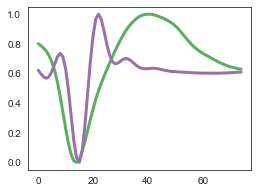

In [34]:
plt.figure(figsize=figsize_gen)


lw = 3

row = results.query('bs==1').sort_values('half_width', ascending=False).iloc[50]
template = data_loader.template(
    row.action, row.channel_group, row.unit_name)

mean_wf = template.data
peak_wf = mean_wf[np.argmin(mean_wf.min(1))]
plt.plot(normalize(peak_wf.T), color=color_bs, lw=lw)


row = results.query('bs==0').sort_values('half_width').iloc[10]
template = data_loader.template(
    row.action, row.channel_group, row.unit_name)

mean_wf = template.data
peak_wf = mean_wf[np.argmin(mean_wf.min(1))]
plt.plot(normalize(peak_wf.T), color=color_ns, lw=lw)

plt.savefig(output_path / "figures" / "example_waveforms.svg", bbox_inches="tight")
plt.savefig(output_path / "figures" / "example_waveforms.png", dpi=600, bbox_inches="tight")

# iverted grid cell

In [46]:
row = results.query('action=="1833-200619-1" and unit_idnum==304').iloc[0]

In [49]:
spikes = data_loader.spike_train(
    row.action, row.channel_group, row.unit_name)

In [51]:
len(spikes) / data_loader.duration(row.action)

array(9.29906418) * 1/s

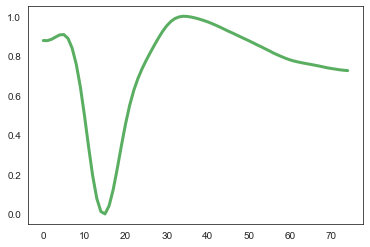

In [48]:
template = data_loader.template(
    row.action, row.channel_group, row.unit_name)

mean_wf = template.data
peak_wf = mean_wf[np.argmin(mean_wf.min(1))]
plt.plot(normalize(peak_wf.T), color=color_bs, lw=lw)

# Store results in Expipe action

In [35]:
action = project.require_action("waveform-analysis")

In [36]:
action.data['results'] = 'results.csv'
results.to_csv(action.data_path('results'), index=False)

In [37]:
stuff = {
    "figures": "figures",
    "statistics": "statistics"
}

for key, value in stuff.items():
    action.data[key] = value
    data_path = action.data_path(key)
    data_path.parent.mkdir(exist_ok=True, parents=True)
    source = output_path / value
    if source.is_file():
        shutil.copy(source, data_path)
    else:
        copy_tree(str(source), str(data_path))

In [38]:
septum_mec.analysis.registration.store_notebook(action, "10_waveform_analysis.ipynb")